
here i want to calculate flow fields around microswimmers with the help of the linear combinaition that is discribed in: DOI: https://doi.org/10.1017/jfm.2012.101


In [209]:
## basic modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # for high resolution displays of plots
fontsize_general = 16
plt.rcParams.update({'font.size': fontsize_general,
                     'axes.titlesize': fontsize_general,
                     'axes.labelsize': fontsize_general,
                     'axes.labelpad': 8,
                     'lines.linewidth': 2,
                     'lines.markersize': 8,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in'})
#import matplotlib as mpl
#mpl.style.use('seaborn-ticks')

######  this is for the pi on the x axis  -----  start
import numpy as np
import matplotlib.pyplot as plt

def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))
    
#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 10))
#ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))    
######  this is for the pi on the x axis  ----- end



import scipy.constants as constants # for physical constants

In [210]:
from scipy.special import eval_legendre
class Flow_field_calculator_stokes_singularities:
    def __init__(self):
        self.particle_radius = 1e-6 #µm
        self.u_0 = 1
    
    def Generate_2D_Grid(self,left = -3e-6, right = 3e-6, N = 20, z = 0):
        x_list = np.linspace(x_min, x_max, N)
        y_list = np.linspace(x_min, x_max, N)
        x_Matrix, y_Matrix = np.meshgrid(x_list, y_list)
        z_Matrix = np.zeros((N,N)) + z
        X_Matrix = np.zeros((3,N,N))
        X_Matrix[0] = x_Matrix
        X_Matrix[1] = y_Matrix
        X_Matrix[2] = z_Matrix
        return X_Matrix
    
    def Stokeslet(self,x, x_0,dir_vec):
        e = dir_vec
        R = np.sqrt(np.dot((x-x_0),(x-x_0)))
        G = 1/np.sqrt(R) * (e + np.dot(e ,(x-x_0) ) * (x-x_0) / R**2 )
        U = G #* f/(8*np.pi*self.mu)
        return U
    
    def Stokeslet_M(self,x_M,x_0,dir_vec):
        # this code is much faster for large number of point to evaluate. (at N = 200x200 there is a timedifference of two orders of magnitude compared to the for loop version)
        e = dir_vec
        e_M = np.zeros_like(x_M)
        e_M[0] = e[0]
        e_M[1] = e[1]
        e_M[2] = e[2]
        x_0_M = np.zeros_like(x_M)
        x_0_M[0] = x_0[0]
        x_0_M[1] = x_0[1]
        x_0_M[2] = x_0[2]

        def dot_M(A,B):
            return np.sum(A * B,axis = 0) 
        R_M = np.sqrt( dot_M((x_M-x_0_M),(x_M-x_0_M)) )
        G_M = 1/R_M * (e_M + dot_M(e_M ,(x_M-x_0_M) ) * (x_M-x_0_M) / R_M**2 )
        U_M = G_M #* f/(8*np.pi*self.mu)
        return U_M
    
    def Stokeslet_Dipole_M(self,x_M,x_0,dir_vec):
        e = dir_vec
        e_M = np.zeros_like(x_M)
        e_M[0] = e[0]
        e_M[1] = e[1]
        e_M[2] = e[2]
        x_0_M = np.zeros_like(x_M)
        x_0_M[0] = x_0[0]
        x_0_M[1] = x_0[1]
        x_0_M[2] = x_0[2]
        
        def dot_M(A,B):
            return np.sum(A * B,axis = 0) 
        R_M = np.sqrt( dot_M((x_M-x_0_M),(x_M-x_0_M)) )
        G_D_M = (x_M-x_0_M)/R_M**3 * (-1 + 3*dot_M(e_M,(x_M-x_0_M))**2/R_M**2 )
        return G_D_M 
    
    def Stokeslet_Quadropole_M(self, x_M, x_0, dir_vec):
        e = dir_vec
        e_M = np.zeros_like(x_M)
        e_M[0] = e[0]
        e_M[1] = e[1]
        e_M[2] = e[2]
        x_0_M = np.zeros_like(x_M)
        x_0_M[0] = x_0[0]
        x_0_M[1] = x_0[1]
        x_0_M[2] = x_0[2]
        x1_M = x_M - x_0_M
        def dot_M(A,B):
            return np.sum(A * B,axis = 0) 
        def scalar_mult_M(a,B):
            a_M = np.zeros_like(B)
            a_M[0] = a
            a_M[1] = a
            a_M[2] = a
            return a_M*B
        R_M = np.sqrt( dot_M((x1_M),(x1_M)) )
        scalar1_M = scalar_mult_M(dot_M(e_M,x1_M), x1_M)
        scalar2_M = scalar_mult_M(dot_M(e_M,x1_M)**2,e_M)
        scalar3_M = scalar_mult_M(dot_M(e_M,x1_M)**3,x1_M)
        G_Q_M = 1/R_M**3 * ( e_M 
                             - (9*scalar1_M + 3*scalar2_M )/R_M**2 
                             + 15* scalar3_M /R_M**4 
                           )
        return G_Q_M
    
    def Source_M(self, x_M,x_0):
        x_0_M = np.zeros_like(x_M)
        x_0_M[0] = x_0[0]
        x_0_M[1] = x_0[1]
        x_0_M[2] = x_0[2]
        
        def dot_M(A,B):
            return np.sum(A * B,axis = 0) 
        R_M = np.sqrt( dot_M((x_M-x_0_M),(x_M-x_0_M)) )
        U_M = (x_M - x_0_M) / R_M**3
        return U_M
    
    def Source_Dipole_M(self, x_M, x_0, dir_vec):
        e = dir_vec
        e_M = np.zeros_like(x_M)
        e_M[0] = e[0]
        e_M[1] = e[1]
        e_M[2] = e[2]
        x_0_M = np.zeros_like(x_M)
        x_0_M[0] = x_0[0]
        x_0_M[1] = x_0[1]
        x_0_M[2] = x_0[2]
        def dot_M(A,B):
            return np.sum(A * B,axis = 0) 
        def scalar_mult_M(a,B):
            a_M = np.zeros_like(B)
            a_M[0] = a
            a_M[1] = a
            a_M[2] = a
            return a_M*B
        
        R_M = np.sqrt( dot_M((x_M-x_0_M),(x_M-x_0_M)) )
        vec1 = scalar_mult_M( dot_M((x_M-x_0_M),e_M) , (x_M - x_0_M) )
        
        U_M = 1/R_M**3 * (-e_M + 3 * vec1 / R_M**2 )
        return U_M
    
    def Source_quadropole_M(self, x_M, x_0, dir_vec):
        e = dir_vec
        e_M = np.zeros_like(x_M)
        e_M[0] = e[0]
        e_M[1] = e[1]
        e_M[2] = e[2]
        x_0_M = np.zeros_like(x_M)
        x_0_M[0] = x_0[0]
        x_0_M[1] = x_0[1]
        x_0_M[2] = x_0[2]
        x1_M = x_M - x_0_M
        def dot_M(A,B):
            return np.sum(A * B,axis = 0) 
        def scalar_mult_M(a,B):
            a_M = np.zeros_like(B)
            a_M[0] = a
            a_M[1] = a
            a_M[2] = a
            return a_M*B
        
        R_M = np.sqrt( dot_M((x_M-x_0_M),(x_M-x_0_M)) )
        scalar1_M = scalar_mult_M(dot_M(e_M,x1_M), e_M)
        scalar2_M = scalar_mult_M(dot_M(e_M,x1_M)**2, x1_M)
        
        U_M = -3/R_M**4 * ( (2*scalar1_M + x1_M)/R_M - 5*scalar2_M/R_M**3  )
        return U_M
    
    

In [211]:

Fields = Flow_field_calculator_stokes_singularities()
x = np.array([1,1,1])
x_0 = np.array([0,0,0])
e = np.array([1,0,0])

#Fields.Stokeslet_Dipole_M(x,x_0,e)
Fields.Source_Dipole_M(x,x_0,e)

array([4.27325041e-17, 1.92450090e-01, 1.92450090e-01])

# Stokeslet

In [212]:
x_min = -3e-6
x_max = -x_min
N = 40
x = np.array([1,1,1])
x_0 = np.array([0,0,0])
e = np.array([1,0,0])
Fields = Flow_field_calculator_stokes_singularities()
X_M = Fields.Generate_2D_Grid(left = x_min, right = x_max, N = N, z = 0)
x_M = X_M[0]
y_M = X_M[1]
z_M = X_M[2]


x_0 = np.array([0,0,0])
e = np.array([1,0,0])

U_M = Fields.Stokeslet_M(X_M, x_0, e)
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]

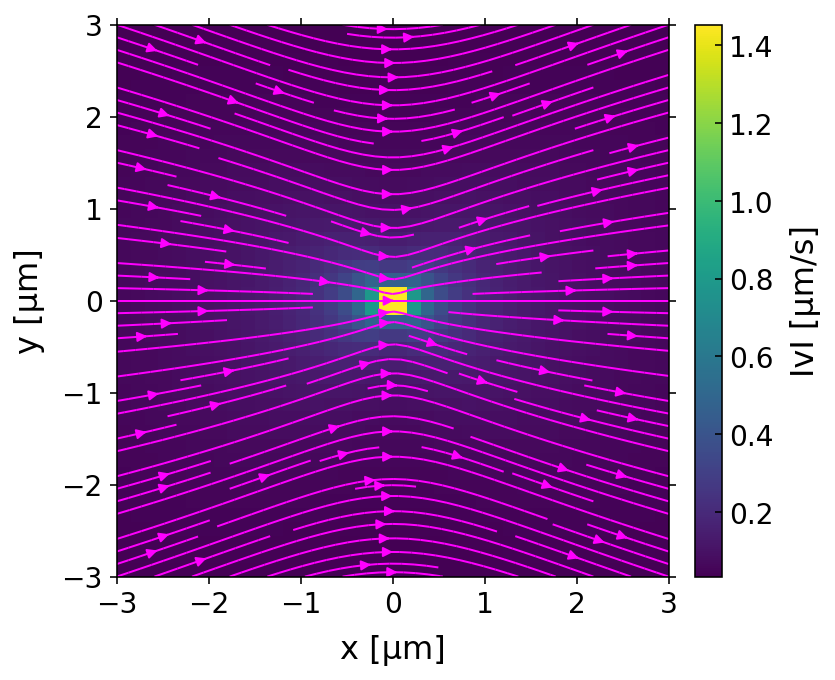

In [213]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1)

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)/1e7, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Stokeslet_streamline_mag_demo.pdf')
plt.show()

# Stokeslet Dipole

In [214]:
x_min = -3e-6
x_max = -x_min
N = 40
X_M = Fields.Generate_2D_Grid(left = x_min, right = x_max, N = N, z = 0)
x_M = X_M[0]
y_M = X_M[1]
z_M = X_M[2]


x_0 = np.array([0,0,0])
e = np.array([1,0,0])

U_M = Fields.Stokeslet_Dipole_M(X_M, x_0, e)
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]


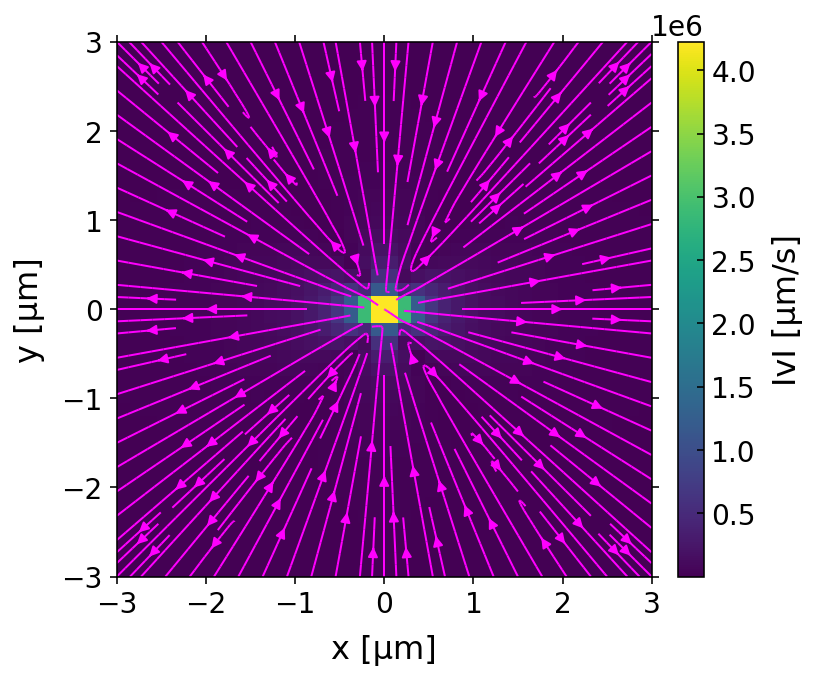

In [215]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1)

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)/1e7, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Stokeslet_dipole_streamline_mag_demo.pdf')
plt.show()

# Stokeslet quadropole

In [216]:
x_min = -3e-6
x_max = -x_min
N = 40
x = np.array([1,1,1])
x_0 = np.array([0,0,0])
e = np.array([1,0,0])
Fields = Flow_field_calculator_stokes_singularities()
X_M = Fields.Generate_2D_Grid(left = x_min, right = x_max, N = N, z = 0)
x_M = X_M[0]
y_M = X_M[1]
z_M = X_M[2]


x_0 = np.array([0,0,0])
e = np.array([1,0,0])

U_M = Fields.Stokeslet_Quadropole_M(X_M, x_0, e)
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]


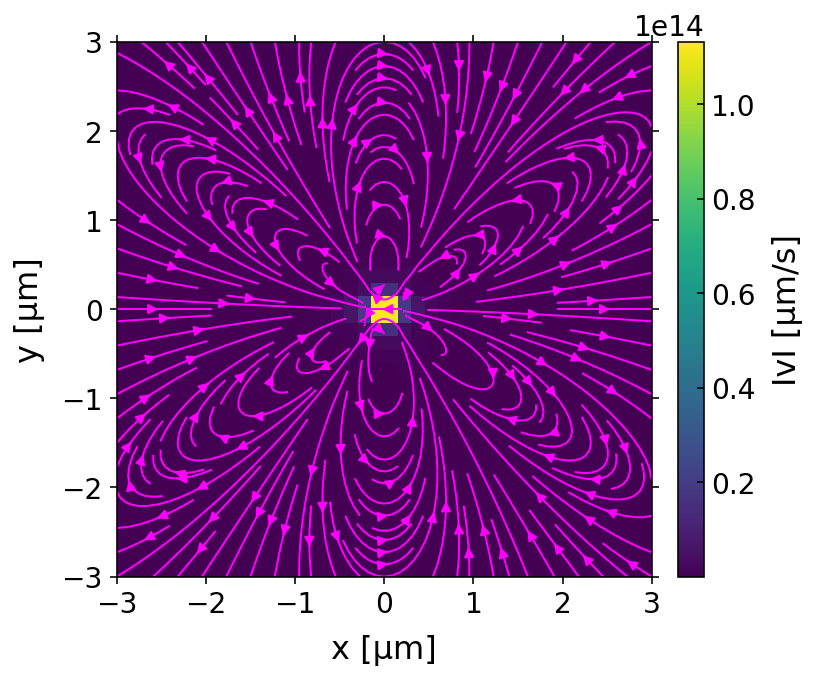

In [217]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1)

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)/1e7, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Stokeslet_quadro_streamline_mag_demo.pdf')
plt.show()

# Source

In [218]:
x_min = -3e-6
x_max = -x_min
N = 40
X_M = Fields.Generate_2D_Grid(left = x_min, right = x_max, N = N, z = 0)
x_M = X_M[0]
y_M = X_M[1]
z_M = X_M[2]


x_0 = np.array([0,0,0])
e = np.array([1,0,0])

U_M = Fields.Source_M(X_M, x_0)
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]


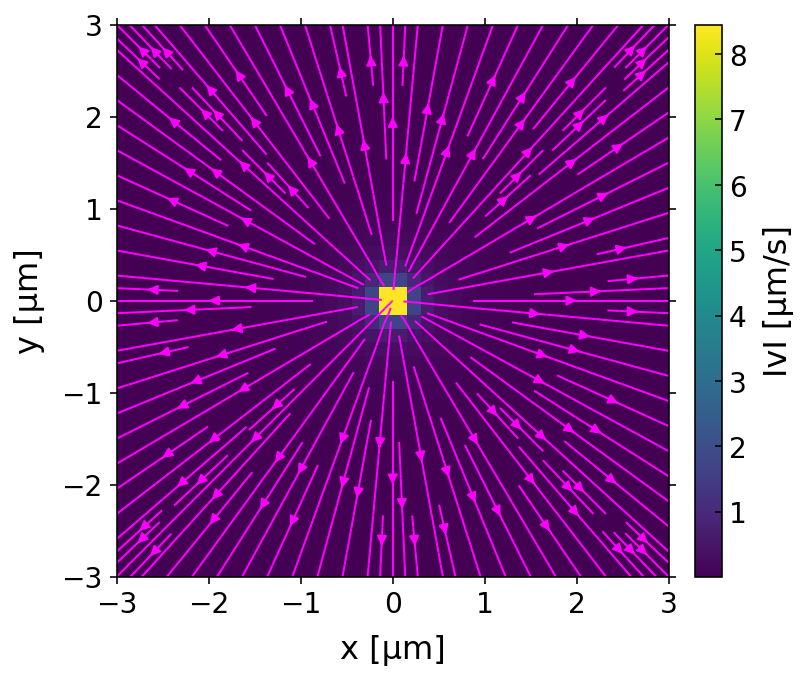

In [219]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1)

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)/1e13, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Source_streamline_mag_demo.pdf')
plt.show()

# source dipole

In [220]:
x_min = -3e-6
x_max = -x_min
N = 40
X_M = Fields.Generate_2D_Grid(left = x_min, right = x_max, N = N, z = 0)
x_M = X_M[0]
y_M = X_M[1]
z_M = X_M[2]


x_0 = np.array([0,0,0])
e = np.array([1,0,0])

U_M = Fields.Source_Dipole_M(X_M, x_0, e)
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]


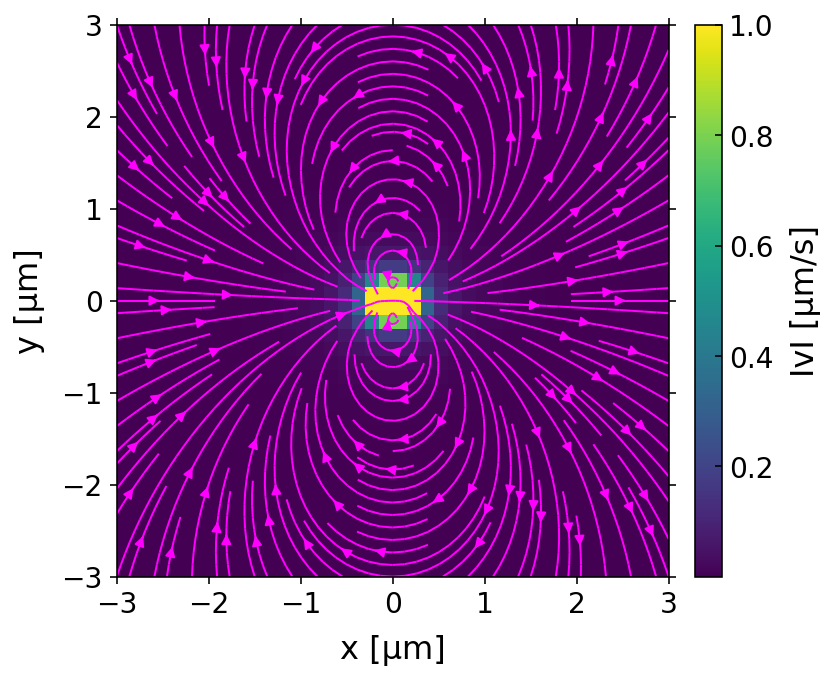

In [221]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1)

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)/1e20,vmax=1, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Source_Dipole_streamline_mag_demo.pdf')
plt.show()

# source quadropole

In [239]:
x_min = -3e-6
x_max = -x_min
N = 100
x = np.array([1,1,1])
x_0 = np.array([0,0,0])
e = np.array([1,0,0])
Fields = Flow_field_calculator_stokes_singularities()
X_M = Fields.Generate_2D_Grid(left = x_min, right = x_max, N = N, z = 0)
x_M = X_M[0]
y_M = X_M[1]
z_M = X_M[2]


x_0 = np.array([0,0,0])
e = np.array([1,0,0])

U_Source_quadropole_M = Fields.Source_quadropole_M(X_M, x_0, e)
U_M = U_Source_quadropole_M * (1e-6/2)**4*1e-6#1e-25
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]

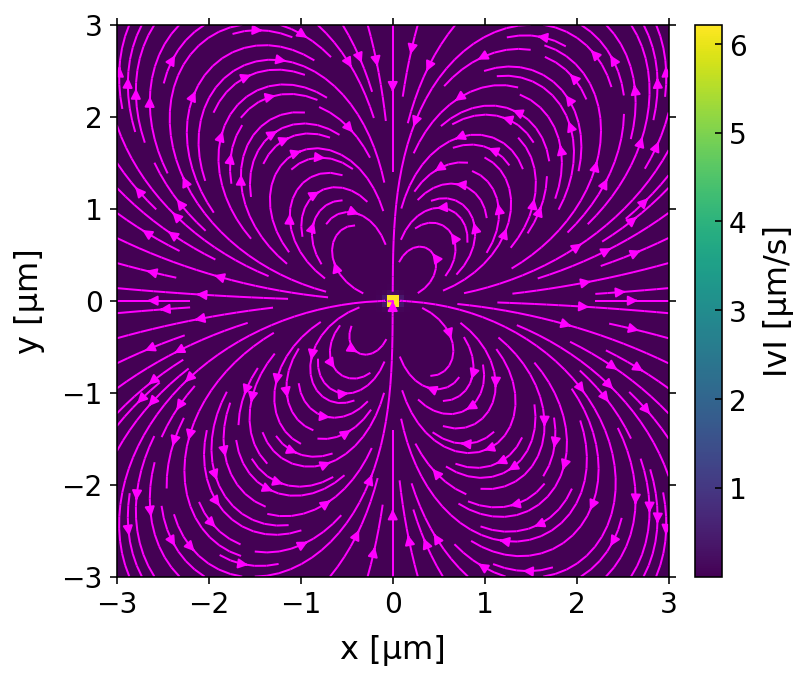

In [247]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1, zorder = 1)

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)*1e2, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

#circle = plt.Circle((0, 0), Fields.particle_radius*1e6, color='grey', fill=True)
#ax.add_patch(circle)
#from matplotlib.patches import Wedge
#wedge = Wedge((0, 0), Fields.particle_radius*1e6, 90, 90 + 180, fc='orange')
#ax.add_patch(wedge)

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Source_quadropole_streamline_demo.pdf')
plt.show()

In [228]:
u_0 = 1e-6 #m/s
u_JP = 2/3*u_0
r_JP = Fields.particle_radius
a = -u_0*r_JP**2/2
b = u_0 * r_JP**3 / 3

U_M = a*U_Stokeslet_Dipole_M + b*U_Source_Dipole_M
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]

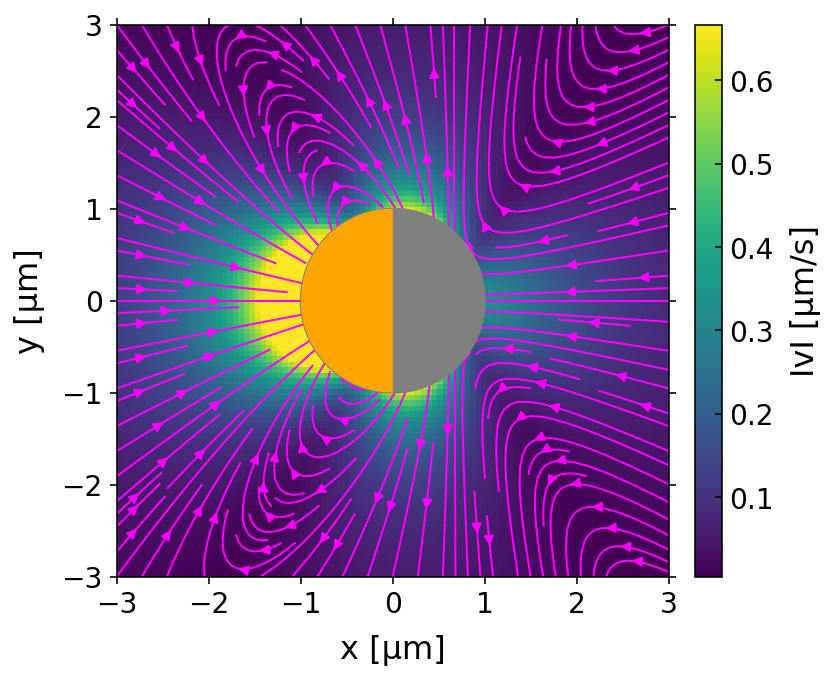

In [229]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1, zorder = 1)

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)*1e6, vmax = 2/3, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

circle = plt.Circle((0, 0), Fields.particle_radius*1e6, color='grey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Stokslet_Dipole_and_SourceDipole_streamline_Janus_particle.pdf')
plt.show()

In [279]:
x_min = -3e-6
x_max = -x_min
N = 100
x = np.array([1,1,1])
x_0 = np.array([0,0,0])
e = np.array([1,0,0])
Fields = Flow_field_calculator_stokes_singularities()
X_M = Fields.Generate_2D_Grid(left = x_min, right = x_max, N = N, z = 0)
x_M = X_M[0]
y_M = X_M[1]
z_M = X_M[2]


x_0 = np.array([0,0,0])
e = np.array([1,0,0])


U_Stokeslet_Dipole_M = Fields.Stokeslet_Dipole_M(X_M, x_0, e)
U_Stokeslet_Quadropole_M = Fields.Stokeslet_Quadropole_M(X_M, x_0, e)
U_Source_Dipole_M = Fields.Source_Dipole_M(X_M, x_0, e)
U_Source_quadropole_M = Fields.Source_quadropole_M(X_M,x_0,e)

In [280]:
u_0 = 1e-6 #m/s
u_JP = 2/3*u_0
r_JP = Fields.particle_radius
a = -u_0*r_JP**2/2
b = u_0 * r_JP**3 / 3 #*4
c = 0#u_0*r_JP**3 / 2
d = u_0*r_JP**4  /6

U_M = a*U_Stokeslet_Dipole_M + b*U_Source_Dipole_M + c * U_Stokeslet_Quadropole_M + d*U_Source_quadropole_M
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]

Fields_lauga_dict = {'x_M':x_M,
                    'y_M':y_M,
                    'u_x_M':u_x_M,
                    'u_y_M':u_y_M}


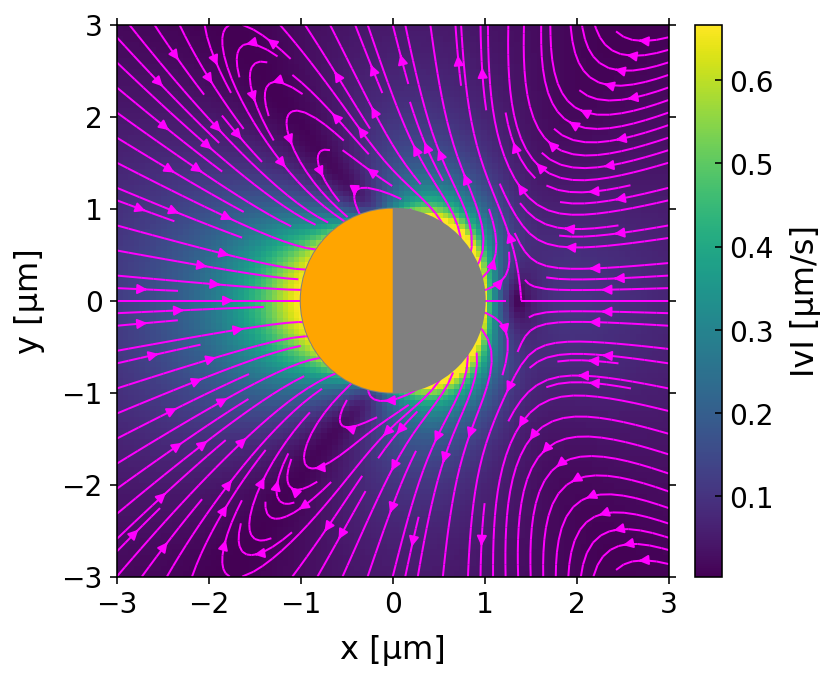

In [281]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1, zorder = 1)

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)*1e6, vmax = 2/3, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

circle = plt.Circle((0, 0), Fields.particle_radius*1e6, color='grey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Superposition_SourceDi_SourceQ_StokesDi_streamline_Janus_particle.pdf')
plt.show()

# trunction at 1/r^3

In [288]:
u_0 = 1e-6 #m/s
u_JP = 2/3*u_0
r_JP = Fields.particle_radius
a = -u_0*r_JP**2/2
b = u_0 * r_JP**3 / 3 #*4
c = 0#u_0*r_JP**3 / 2
d = u_0*r_JP**4  /6

U_M = d*U_Source_quadropole_M
u_x_M = U_M[0]
u_y_M = U_M[1]
u_z_M = U_M[2]

U_M = a*U_Stokeslet_Dipole_M + b*U_Source_Dipole_M + d*U_Source_quadropole_M
u_x_M1 = U_M[0]
u_y_M1 = U_M[1]
u_z_M1 = U_M[2]

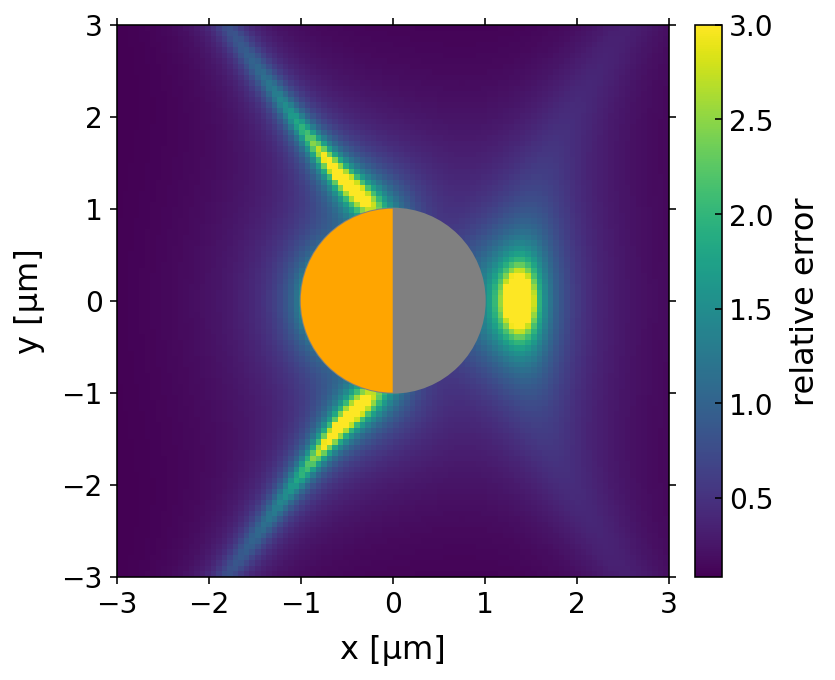

In [313]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
#S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1, zorder = 1)

u_JP = 2/3
transparency_M = np.sqrt(u_x_M1**2+u_y_M1**2 + u_z_M1**2)*1e6/u_JP
transparency_M[transparency_M>1] = 1



im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)/np.sqrt(u_x_M1**2+u_y_M1**2 + u_z_M1**2),vmax = 3, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'relative error')


circle = plt.Circle((0, 0), Fields.particle_radius*1e6, color='grey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Relative_error_without_Q_Janus_particle.pdf')
plt.show()

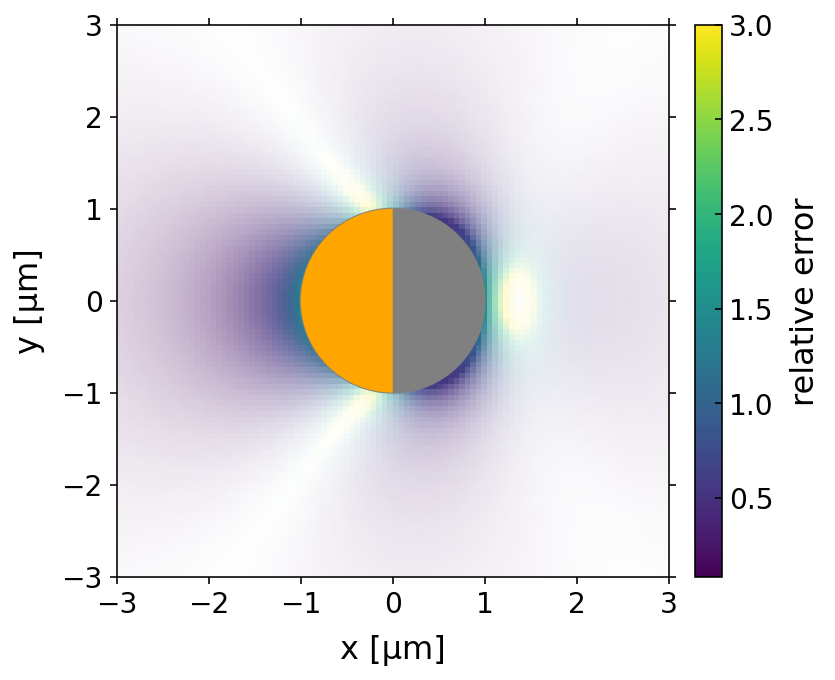

In [314]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

#Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, u_x_Matrix, u_y_Matrix)
#S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1, zorder = 1)

u_JP = 2/3
transparency_M = np.sqrt(u_x_M1**2+u_y_M1**2 + u_z_M1**2)*1e6/u_JP
transparency_M[transparency_M>1] = 1



im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)/np.sqrt(u_x_M1**2+u_y_M1**2 + u_z_M1**2),vmax = 3, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'relative error')

im.remove()

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)/np.sqrt(u_x_M1**2+u_y_M1**2 + u_z_M1**2),vmax = 3, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6],alpha = transparency_M, cmap = 'viridis', zorder = 0)


circle = plt.Circle((0, 0), Fields.particle_radius*1e6, color='grey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")

plt.tight_layout()
plt.savefig('Relative_error_with_absolute_as_transparent_without_Q_Janus_particle.pdf')
plt.show()

# Würger and Bickel

In [234]:
from scipy.special import eval_legendre
class Fields_Calculator:
    def __init__(self):
        self.Particle_radius = 1e-6 #µm
        
        # for the temperature calcualtion
        self.T_0 = 300 # Kelvin
        self.Delta_T = 1 # Kelvin
        self.n_max = 10
        self.u_0 = 1*1e-6
        self.iso_gold_cap = True
        
    
    def Generate_sum_coefficients(self):
        self.df_coeff = pd.DataFrame({'n': np.arange(0,self.n_max+3,1)}, index = np.arange(0,self.n_max+3,1).astype('int')) # the + 2 is due to the relevane of two more coeff in the v calculation
        
        self.df_coeff.loc[:,['t']] = np.zeros(len(self.df_coeff)) 
        for n in self.df_coeff.n.values:
            if n == 0:
                self.df_coeff.loc[0,['t']] = 1 + np.pi/2
            if n % 2 == 1: # the 2k +1
                self.df_coeff.loc[n,['t']] = - self.df_coeff.loc[n-1,['t']].values
            elif n % 2 == 0: # the 2k 
                self.df_coeff.loc[n,['t']] = (-1)**(n/2) / (n+1)
        self.df_coeff.loc[0,['t']] = 1 + np.pi/2
        
        # for the velocity calculation
        self.df_coeff.loc[:,['p_fixed']] = np.zeros(len(self.df_coeff))
        self.df_coeff.loc[:,['q_fixed']] = np.zeros(len(self.df_coeff))
        for n in self.df_coeff.n.values:
            self.df_coeff.loc[n,['p_fixed']] = n * (n+1)/2 * self.df_coeff.t[n]
            if n >= 2:
                self.df_coeff.loc[n,['q_fixed']] = -self.df_coeff.loc[n-2,['p_fixed']].values
        self.df_coeff.loc[:,['p_moving']] = self.df_coeff.loc[:,['p_fixed']].values
        self.df_coeff.loc[:,['q_moving']] = self.df_coeff.loc[:,['q_fixed']].values
        self.df_coeff.loc[1,['p_moving']] = 0
        self.df_coeff.loc[3,['q_moving']] = 2/3
        
    
    def Temperature(self,r,theta):
        a = self.Particle_radius
        T_0 = self.T_0
        Delta_T = self.Delta_T
        n_min = 0
        n_max = self.n_max
        mask = self.df_coeff.n <= n_max
        n_list = self.df_coeff.n[mask].values
        t_list = self.df_coeff.t[mask].values
        P_list = np.zeros(len(n_list))
        c = np.cos(theta)
        for i in range(len(P_list)):
            n = n_list[i]
            # Legendre polynomials
            P_list[i] = eval_legendre(n, c)
        if r > self.Particle_radius:
            T = T_0 + Delta_T/np.pi * np.sum(t_list*P_list*(a/r)**(n_list+1))
        else:
            T = T_0 + Delta_T/np.pi * np.sum(t_list*P_list*(r/a)**(n_list))
        return T
    
    def surface_creep_flow(self,theta):
        u_0 = self.u_0
        n_max = self.n_max
        mask = (self.df_coeff.n <= n_max)
        n_list = self.df_coeff.n[mask].values
        t_list = self.df_coeff.t[mask].values
        P_list = np.zeros(len(n_list))
        P_derivative_list = np.zeros(len(n_list))
        c = np.cos(theta)
        dc_dtheta = - np.sin(theta)
        for i in range(len(P_list)):
            n = n_list[i]
            # Legendre polynomials
            P_list[i] = eval_legendre(n, c)
            if n > 0:
                P_derivative_list[n] = n*P_list[n-1] + c*P_derivative_list[n-1]
        value = u_0 * np.sum(t_list[1:] * P_derivative_list[1:]) * dc_dtheta
        return value
    
    def velocity_radial(self,r,theta, mode = 'fixed'):
        if r < self.Particle_radius:
            return 0
        a = self.Particle_radius
        v_0 = self.u_0
        n_max = self.n_max
        mask = (self.df_coeff.n <= n_max) & (self.df_coeff.n > 0)
        mask_q = (self.df_coeff.n <= n_max+2) & (self.df_coeff.n > 2)
        n_list = self.df_coeff.n[mask].values
        if mode == 'fixed':
            p_list = self.df_coeff.p_fixed[mask].values
            q_list = self.df_coeff.q_fixed[mask_q].values
        elif mode == 'moving':
            p_list = self.df_coeff.p_moving[mask].values
            q_list = self.df_coeff.q_moving[mask_q].values
        c = np.cos(theta)
        P_list = np.zeros(len(self.df_coeff.n.values))
        for i in range(len(P_list)):
            n = self.df_coeff.n.values[i]
            # Legendre polynomials
            P_list[i] = eval_legendre(n, c)
        P_list = P_list[1:-2]

        value = v_0 * np.sum( (a/r)**n_list * (p_list + q_list*(a/r)**2) * P_list )
        return value
    
    def velocity_theta(self,r,theta, mode = 'fixed'):
        if r < self.Particle_radius:
            return 0
        a = self.Particle_radius
        v_0 = self.u_0
        n_max = self.n_max
        mask = (self.df_coeff.n <= n_max) & (self.df_coeff.n > 0)
        mask_q = (self.df_coeff.n <= n_max+2) & (self.df_coeff.n > 2)
        n_list = self.df_coeff.n[mask].values
        if mode == 'fixed':
            p_list = self.df_coeff.p_fixed[mask].values
            q_list = self.df_coeff.q_fixed[mask_q].values
        elif mode == 'moving':
            p_list = self.df_coeff.p_moving[mask].values
            q_list = self.df_coeff.q_moving[mask_q].values
        c = np.cos(theta)
        s = np.sin(theta)
        P_list = np.zeros(len(self.df_coeff.n.values))
        P_derivative_list = np.zeros(len(self.df_coeff.n.values))
        for i in range(len(P_list)):
            n = self.df_coeff.n.values[i]
            # Legendre polynomials
            P_list[i] = eval_legendre(n, c)
            if n > 0:
                P_derivative_list[i] = n*P_list[i-1] + c*P_derivative_list[i-1]
        P_list = P_list[1:-2]
        P_derivative_list = P_derivative_list[1:-2]
        value = v_0 * s * np.sum((a/r)**n_list * (p_list*(n_list-2)/(n_list*(n_list+1)) + q_list/(n_list+1)*(a/r)**2)*P_derivative_list)
        return value


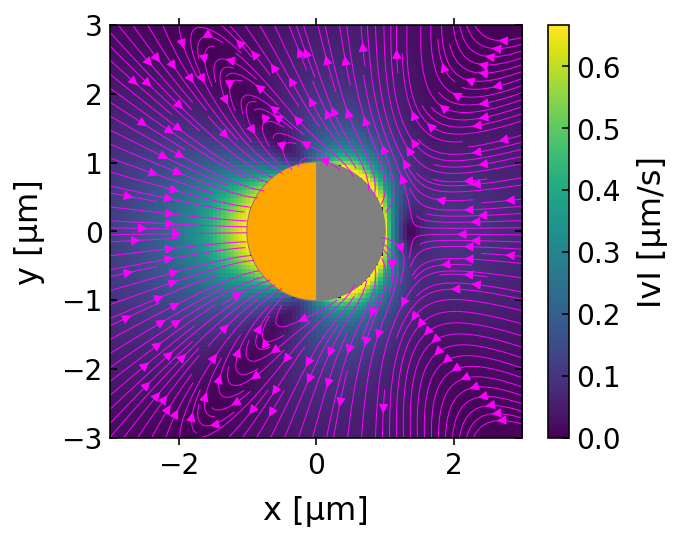

In [207]:
fig, ax = plt.subplots(1,1, figsize = (5,5))


Fields = Fields_Calculator()
Fields.n_max = 2
Fields.Generate_sum_coefficients()
x_min = -3e-6
x_max = -x_min
N = 100
x_list = np.linspace(x_min, x_max, N)
y_list = np.linspace(x_min, x_max, N)
x_Matrix, y_Matrix = np.meshgrid(x_list, y_list)


r_Matrix = np.sqrt(x_Matrix**2 + y_Matrix**2)
theta_Matrix = np.arctan2(y_Matrix,x_Matrix)
v_radial_Matrix = np.zeros_like(r_Matrix)
v_theta_Matrix = np.zeros_like(r_Matrix)
for i_y in range(N):
    for j_x in range(N):
        v_radial_Matrix[i_y,j_x] = Fields.velocity_radial(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'moving')
        v_theta_Matrix[i_y,j_x] = Fields.velocity_theta(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'moving')        
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
im = ax.imshow(np.sqrt(v_theta_Matrix**2+v_radial_Matrix**2)*1e6, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0, vmax = 2/3)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')
v_x_Matrix = v_radial_Matrix * np.cos(theta_Matrix) - v_theta_Matrix * np.sin(theta_Matrix)
v_y_Matrix = v_radial_Matrix * np.sin(theta_Matrix) + v_theta_Matrix * np.cos(theta_Matrix)
#Q = ax.quiver(x_Matrix, y_Matrix, v_x_Matrix, v_y_Matrix)
S = ax.streamplot(x_Matrix*1e6, y_Matrix*1e6, v_x_Matrix, v_y_Matrix, density=[2, 2],color = 'magenta', linewidth = 0.5)

circle = plt.Circle((0, 0), Fields.Particle_radius*1e6, color='grey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.Particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)

ax.tick_params(axis="x",direction="out")

plt.tight_layout()
#plt.savefig('moving_JP_fluid_flow_field_streamline_mag_xy_n100.pdf')
plt.show()


Fields_bickel_dict = {'x_M':x_Matrix,
                    'y_M':y_Matrix,
                    'u_x_M':v_x_Matrix,
                    'u_y_M':v_y_Matrix}




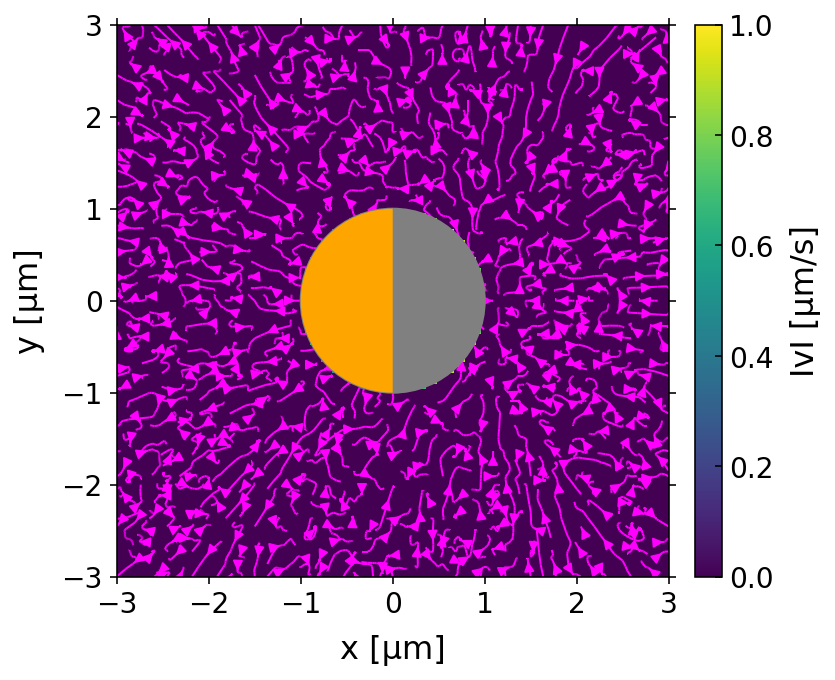

In [208]:

fig, ax = plt.subplots(1,1,figsize=(6,5)) 

ax.set_xlabel('x [µm]') 
ax.set_ylabel('y [µm]') 


u_x_M = Fields_bickel_dict['u_x_M'] - Fields_lauga_dict['u_x_M'] 
u_y_M = Fields_bickel_dict['u_y_M'] - Fields_lauga_dict['u_y_M'] 

S = ax.streamplot(x_M*1e6, y_M*1e6, u_x_M, u_y_M, density=[1.5, 1.5],color = 'magenta', linewidth = 1, zorder = 1) 

im = ax.imshow(np.sqrt(u_x_M**2+u_y_M**2 + u_z_M**2)*1e6, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0, vmax = 1) 
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18) 
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]') 

circle = plt.Circle((0, 0), 1, color='grey', fill=True) 
ax.add_patch(circle) 
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), 1, 90, 90 + 180, fc='orange') 
ax.add_patch(wedge) 

ax.tick_params(axis="y",direction="out") 
ax.tick_params(axis="x",direction="out") 

plt.tight_layout() 
plt.savefig('JP_flowField_LaugaVSbickel_streamline_mag.pdf') 
plt.show() 


Frank's decomposition is (from Slack):

$u_r(r,\theta) = \frac{2}{3} \left( \frac{a^3}{r^3} -1\right) B_1 P_1(\cos(\theta)) + \sum^\infty_{n=2}  \left( \frac{a^{n+2}}{r^{n+2}} - \frac{a^n}{r^n} \right) B_n P_n(\cos(\theta)) $ 

$ u_\theta(r,\theta) = \frac{2}{3} \left( \frac{a^3}{r^3} + 1\right) B_1 P'_1(\cos(\theta)) + \sum^\infty_{n=2}  \frac{1}{2} \left( n\frac{a^{n+2}}{r^{n+2}} + (2-n) \frac{a^n}{r^n} \right) B_n P'_n(\cos(\theta)) $

Alois's decomposition is(DOI:https://doi.org/10.1103/PhysRevE.88.012301):


$u_r(r,\theta) = u_0 \sum^\infty_{n=1} \frac{a^{n}}{r^{n}} \left( p_n -q_{n+2} \frac{a^2}{r^2} \right) P_n(\cos(\theta)) $ 

(after inserting $p_n = -q_{n+2}$): 

$u_r(r,\theta) = u_0 \sum^\infty_{n=1} p_n\frac{a^{n}}{r^{n}} \left( 1 - \frac{a^2}{r^2} \right) P_n(\cos(\theta)) $ 

$ u_\theta(r,\theta) = u_0 \sin(\theta) \sum^\infty_{n=1} \frac{a^{n}}{r^{n}} \left( p_n\frac{n-2}{n(n-1)} + \frac{q_{n+2}}{n+1} \frac{a^2}{r^2} \right) P'_n(\cos(\theta)) $

where for a moving particle:

$p_1 = 0$ and $q_3 = -\frac{2}{3}t_1 = \frac{2}{3}$

and

$p_n = -q_{n+2} = \frac{n(n+1)}{2} t_n$  for  $(n \geq 2)$

with 

$t_{2k} = -t_{2k+1} = \frac{(-1)^k}{2k+1}$

the propulsion speed is

$u_p = q_3 u_0 = \frac{2}{3} u_0$

For the immobile particle the first relevant coefficients change to

$p_1=-1$ and $q_3 = 1$ and $t_1 = -1$

The next relevant coefficents are in both cases:

$p_2 = -1$ and $q_4 = 1$ and $t_2 = -1/3$

Legendre Polynoms are:

$P_1(c) = c$

$P_2(c) = \frac{1}{2}(3c^2-1)$

---

Comparison of Würger VS Frank's:

$\frac{2}{3} \left( \frac{a^3}{r^3} -1\right) B_1 \stackrel{?}{=} u_0 \frac{a^{1}}{r^{1}} \left( p_1 -q_{1+2} \frac{a^2}{r^2} \right)  = u_0  q_{3} \frac{a^3}{r^3} = -\frac{2}{3} u_0\frac{a^3}{r^3}$ --> $B_1 = u_0$ and Frank's has the additional background term 2/3 u_0, so its in the particle frame

$B_1 = - u_0 p_n$

decompositon done by Lauga:






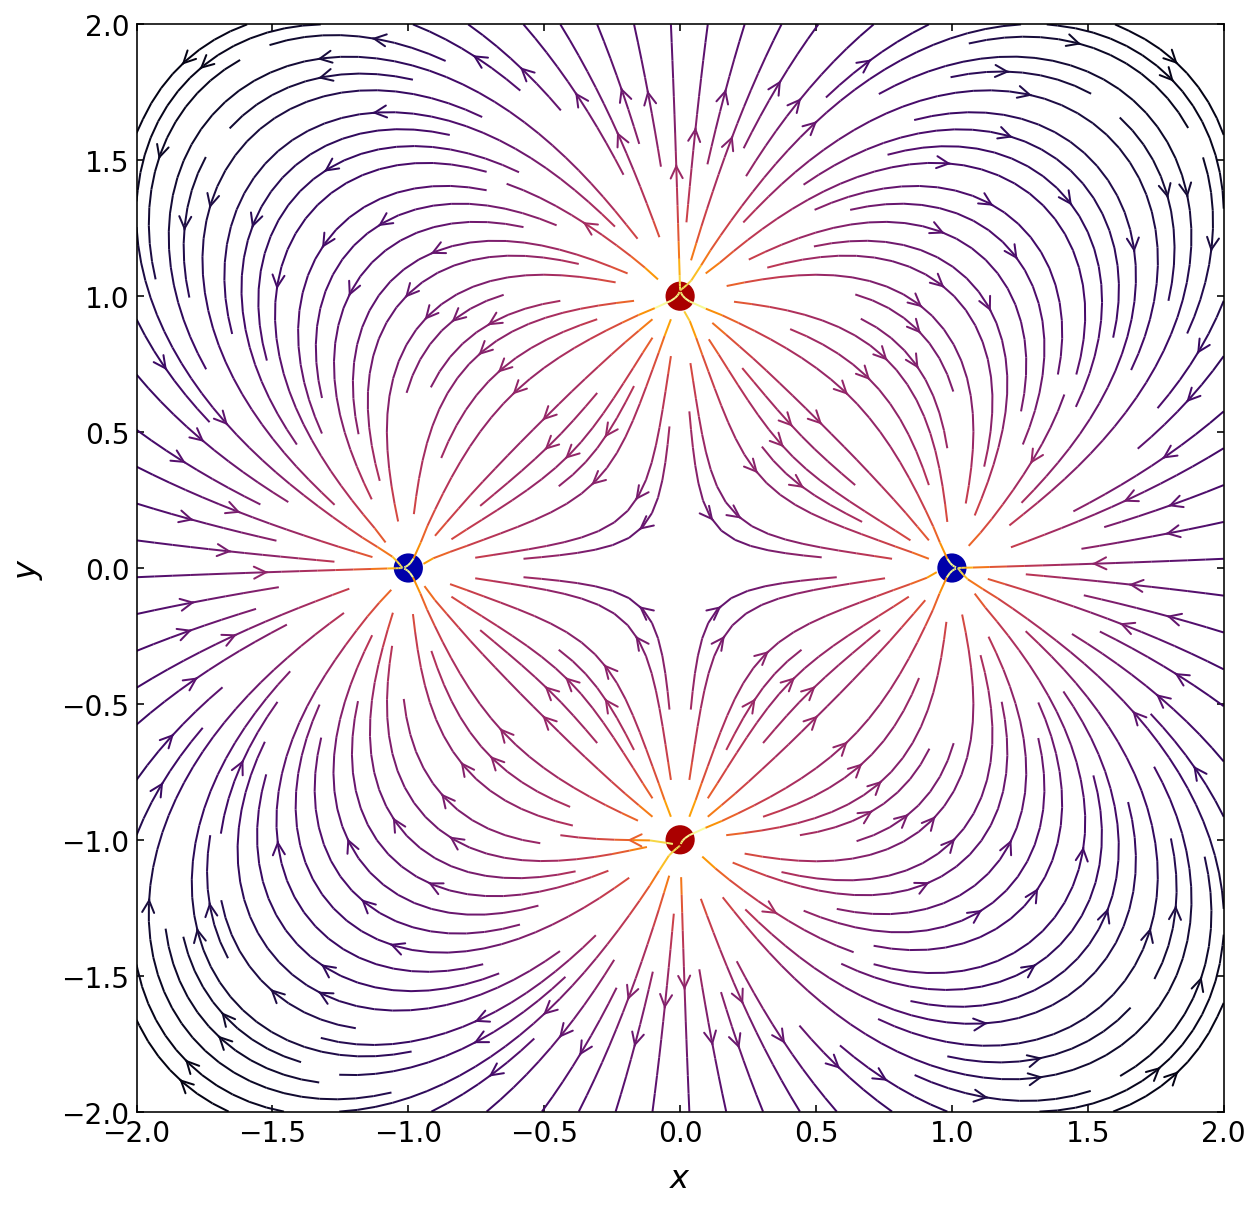

In [130]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def E(q, r0, x, y):
    """Return the electric field vector E=(Ex,Ey) due to charge q at r0."""
    den = np.hypot(x-r0[0], y-r0[1])**3
    return q * (x - r0[0]) / den, q * (y - r0[1]) / den

# Grid of x, y points
nx, ny = 64, 64
x = np.linspace(-2, 2, nx)
y = np.linspace(-2, 2, ny)
X, Y = np.meshgrid(x, y)

# Create a multipole with nq charges of alternating sign, equally spaced
# on the unit circle.
nq = 4#2**int(sys.argv[1])
charges = []
r = 1
for i in range(nq):
    q = i%2 * 2 - 1
    charges.append((q, (r*np.cos(2*np.pi*i/nq), r*np.sin(2*np.pi*i/nq))))

# Electric field vector, E=(Ex, Ey), as separate components
Ex, Ey = np.zeros((ny, nx)), np.zeros((ny, nx))
for charge in charges:
    ex, ey = E(*charge, x=X, y=Y)
    Ex += ex
    Ey += ey

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Ex, Ey))
ax.streamplot(x, y, Ex, Ey, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: '#aa0000', False: '#0000aa'}
for q, pos in charges:
    ax.add_artist(Circle(pos, 0.05, color=charge_colors[q>0]))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_aspect('equal')
plt.show()


In [112]:
sys.argv[1]

'-f'

In [114]:
int( float(sys.argv[1]))

ValueError: could not convert string to float: '-f'

In [118]:
import os
[os.fsencode(arg) for arg in sys.argv]

[b'/Users/nicola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py',
 b'-f',
 b'/Users/nicola/Library/Jupyter/runtime/kernel-9e1a675a-0747-4e7c-b734-9e2bee4d6b55.json']